In [1]:
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

from sklearn.linear_model import LinearRegression

from NeuralGraph import NeuralGraph

c:\Users\bunna\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [3]:
def split_dataset(x, y, valid_split=.2, test_split=.2):
    classes = np.unique(y)
    train_valid_split = round(len(classes)*(1-(valid_split+test_split)))
    valid_test_split = round(len(classes)*(1-test_split))

    train_classes = set(classes[:train_valid_split])
    valid_classes = set(classes[train_valid_split:valid_test_split])
    test_classes = set(classes[valid_test_split:])

    train = {i:[] for i in train_classes}
    valid = {i:[] for i in valid_classes}
    test = {i:[] for i in test_classes}

    for data, class_ in zip(x, y):
        if class_ in train_classes:
            train[class_].append(data)
        
        elif class_ in valid_classes:
            valid[class_].append(data)

        else:
            test[class_].append(data)

    for class_ in train_classes:
        train[class_] = np.stack(train[class_])

    for class_ in valid_classes:
        valid[class_] = np.stack(valid[class_])

    for class_ in test_classes:
        test[class_] = np.stack(test[class_])

    return train, valid, test

In [4]:
SIZE = 32

(x, y), (_, _) = tf.keras.datasets.cifar100.load_data()
y = y.flatten()
x = np.mean(np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2, 3), axis=-1)

cifar_train, cifar_valid, cifar_test = split_dataset(x, y)

(x, y), (_, _) = tf.keras.datasets.mnist.load_data()
x = np.stack([cv2.resize(img/255.0, dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

mnist_train, mnist_valid, mnist_test = split_dataset(x, y)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])


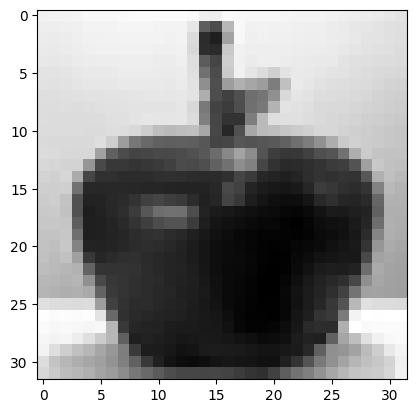

dict_keys([8, 9])


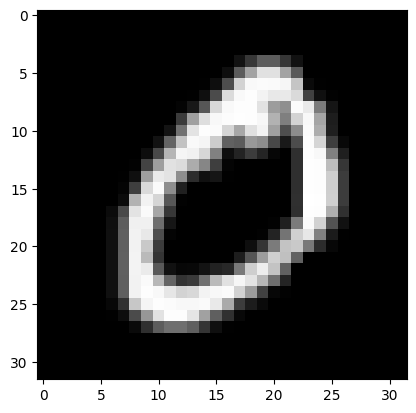

In [5]:
print(cifar_train.keys())
# print(cifar_train[0].shape)
plt.imshow(cifar_train[0][2].reshape(SIZE, SIZE), cmap="gray")# [list(train[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

print(mnist_test.keys())
# print(cifar_train[0].shape)
plt.imshow(mnist_train[0][0].reshape(SIZE, SIZE), cmap="gray")# [list(train[0].keys())[0]][0].reshape(SIZE, SIZE))
plt.show()

In [6]:
BATCH_SIZE = 16
TIME = 1
DT = .25

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

criterion = nn.MSELoss()

In [6]:
shape = [SIZE**2, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, ch_n_const=4, ch_e_const=2, value_init="random", init_value_std=1, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

2048


In [31]:
# import networkx as nx

# g = nx.DiGraph()
# g.add_nodes_from(list(range(graph.n_nodes)))
# g.add_edges_from(graph.connections)

# pos = {i:np.array([i%SIZE, i//SIZE]) for i in range(SIZE**2)}

# pos[SIZE**2] = np.array([SIZE+2, SIZE//2 - 2])
# pos[SIZE**2 + 1] = np.array([SIZE+2, SIZE//2 + 2])

# nx.draw(g, pos)

In [7]:
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

### Memorize Task
##### Repeat input/output pairs in order they're given

In [33]:
STEPS = 3_000
EXAMPLES = 10
log = []

In [36]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  1%|          | 34/3000 [00:15<22:46,  2.17it/s, loss=0.0237, acc=1, overflow=0.00013]     


KeyboardInterrupt: 

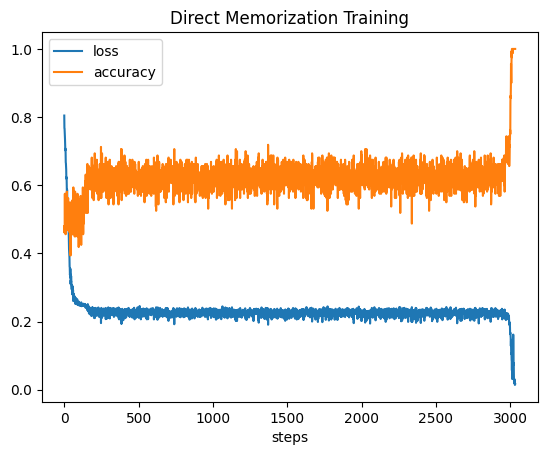

In [37]:
plt.title("Direct Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.xlabel("steps")

plt.savefig("direct_memorize.png", dpi=500)
plt.show()

graph.save("models/direct_memorize.pt")

### Now train again with hidden layers

In [15]:
shape = [SIZE**2, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

BATCH_SIZE = 4

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, ch_n_const=4, ch_e_const=2, value_init="random", init_value_std=1, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

8208


In [16]:
graph.load("models/direct_memorize.pt")

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 10_000
EXAMPLES = 10
log = []

In [18]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  5%|▍         | 481/10000 [03:28<1:08:41,  2.31it/s, loss=0.0162, acc=1, overflow=0.000359]    


KeyboardInterrupt: 

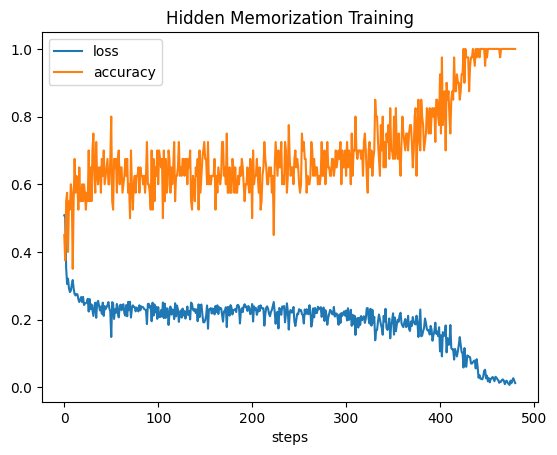

In [19]:
plt.title("Hidden Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.xlabel("steps")

plt.savefig("hidden_memorize.png", dpi=500)
plt.show()

In [20]:
graph.save("models/hidden_memorize.pt")

### Now again with Conv Layers

In [7]:
inp_nodes = np.arange(SIZE**2).reshape(1, SIZE, SIZE)
conv1_start = SIZE**2
conv1_nodes = np.arange(conv1_start, conv1_start+4*((SIZE-4)//2)**2).reshape(4, (SIZE-4)//2, (SIZE-4)//2)
curr_size = (SIZE-4)//2
conv2_start = conv1_start + 4*curr_size**2
conv2_nodes = np.arange(conv2_start, conv2_start+4*((curr_size-4)//2)**2).reshape(4, (curr_size-4)//2, (curr_size-4)//2)
curr_size = (curr_size-4)//2

output_start = conv2_start+4*curr_size**2
output_nodes = np.arange(output_start, output_start+n_classes)

n_nodes = output_start+n_classes

print(inp_nodes, inp_nodes.shape)
print(conv1_nodes, conv1_nodes.shape)
print(conv2_nodes, conv2_nodes.shape)
print(output_nodes, output_nodes.shape)
print(n_nodes)

const_n = np.zeros((n_nodes, 4))
const_n[:conv1_start, 0] = 1 # Label grid nodes
const_n[conv1_start:conv2_start, 1] = 1 # Label conv1 nodes
const_n[conv2_start:output_start, 2] = 1 # Label conv1 nodes
const_n[output_start:, 3] = 1 # Label conv1 nodes

[[[   0    1    2 ...   29   30   31]
  [  32   33   34 ...   61   62   63]
  [  64   65   66 ...   93   94   95]
  ...
  [ 928  929  930 ...  957  958  959]
  [ 960  961  962 ...  989  990  991]
  [ 992  993  994 ... 1021 1022 1023]]] (1, 32, 32)
[[[1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037]
  [1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051]
  [1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065]
  [1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079]
  [1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093]
  [1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107]
  [1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121]
  [1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135]
  [1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149]
  [1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163]
  [1164 1165

In [8]:
connections = []
const_e = []

# conv1 connections
for ch in range(len(conv1_nodes)):
    for x in range(len(conv1_nodes[ch])):
        for y in range(len(conv1_nodes[ch, x])):
            # Get the subgrid
            for x_off in range(4):
                for y_off in range(4):
                    connections.append((inp_nodes[0, 2*x+x_off, 2*y+y_off], conv1_nodes[ch, x, y]))
                    const_e.append([x_off-1.5, y_off-1.5])

# conv2 connections
for ch2 in range(len(conv2_nodes)):
    for x in range(len(conv2_nodes[ch2])):
        for y in range(len(conv2_nodes[ch2, x])):
            # Get the subgrid
            for x_off in range(4):
                for y_off in range(4):
                    for ch1 in range(len(conv1_nodes)):
                        connections.append((conv1_nodes[ch1, 2*x+x_off, 2*y+y_off], conv2_nodes[ch2, x, y]))
                        const_e.append([x_off-1.5, y_off-1.5])

# Output connections
for n in output_nodes:
    for ch2 in range(len(conv2_nodes)):
        for x in range(len(conv2_nodes[ch2])):
            for y in range(len(conv2_nodes[ch2, x])):
                connections.append((conv2_nodes[ch2, x, y], n))
                const_e.append([0, 0])

print(len(connections))

19144


In [9]:
BATCH_SIZE = 4

print(len(connections))

graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
    ch_n=8, ch_e=8, ch_n_const=4, ch_e_const=2, value_init="random", init_value_std=1, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

log = []

19144


In [11]:
graph.load("models/hidden_memorize.pt")

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 10_000
EXAMPLES = 10
log = []

In [13]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  1%|▏         | 144/10000 [01:08<1:18:28,  2.09it/s, loss=0.00484, acc=1, overflow=0.000306]  


KeyboardInterrupt: 

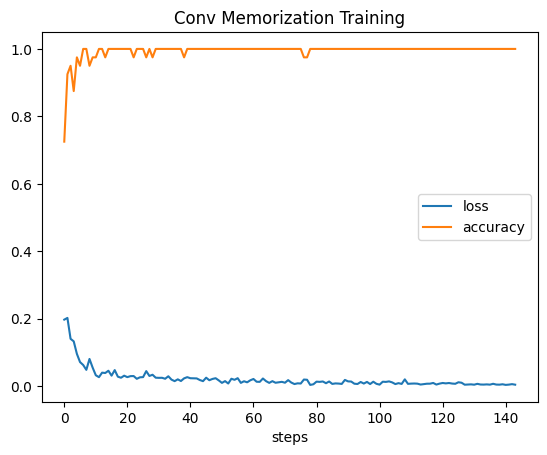

In [15]:
plt.title("Conv Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.plot([e['acc'] for e in log], label="accuracy")
plt.legend()
plt.xlabel("steps")

# plt.savefig("hidden_memorize.png", dpi=500)
plt.show()

In [16]:
graph.save("models/conv_memorize.pt")

### Generalization Task
##### Given input/output pairs from a specific task, given output from unseen input data from that task

In [6]:
# BATCH_SIZE = 8
# TIME = 1
# DT = .25

# n_classes = 2
# device = "cuda" if torch.cuda.is_available() else "cpu"


# shape = [SIZE**2, 8, n_classes]
# n_nodes = sum(shape)
# connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

# print(len(connections))

# graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections,
#     ch_n=8, ch_e=8, value_init="trainable", init_value_std=.05, 
#     aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
#     device=device)

# graph.load_rules("models/memorize")

# log = []

8208


In [11]:
TRAIN_EXAMPLES = 10
TEST_EXAMPLES = 10
# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)
criterion = nn.MSELoss()

STEPS = 100_000

log = []

In [12]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

def get_batch_data(dataset=[cifar_train], batch_size=BATCH_SIZE, train_examples=TRAIN_EXAMPLES, test_examples=TEST_EXAMPLES):
    if type(dataset) != list:
        dataset = [dataset]
    set_ = np.random.randint(len(dataset), size=(batch_size))

    classes = np.stack([np.random.choice(list(dataset[i].keys()), size=(n_classes), replace=False) for i in set_])
    
    # This gets completely random examples
    # y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    # y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))

    # This gets balanced random examples
    
    y_train = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, train_examples)), axis=0), batch_size, axis=0).astype(np.int32)
    y_test = np.repeat(np.expand_dims(np.round(np.linspace(0, n_classes-1, test_examples)), axis=0), batch_size, axis=0).astype(np.int32)

    y_train = shuffle_along_axis(y_train, axis=1)
    y_test = shuffle_along_axis(y_test, axis=1)


    x_train = []
    for batch_classes, y, i in zip(classes, y_train, set_):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(dataset[i][class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    x_test = []
    for batch_classes, y, i in zip(classes, y_test, set_):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(dataset[i][class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [38]:
bar = tqdm(range(1, STEPS+1))
for step in bar:

    # Train step
    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=cifar_train)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()


    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()


    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_test).float().mean()

    task_loss = criterion(pred, y_label)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    # Valid step
    with torch.no_grad():
        x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=cifar_valid)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()

        graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

        graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = graph.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        valid_acc = (pred.argmax(2) == y_test).float().mean()
        valid_loss = criterion(pred, y_label)

    # Save
    if step % 500 == 0 and step != 0:
        graph.save(f"models/generalize_{step}.pt")

    entry = {'valid_loss':valid_loss.item(), 'valid_acc':valid_acc.item(), 'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"valid_loss":np.mean([e["valid_loss"] for e in log[-10:]]), "valid_acc":np.mean([e["valid_acc"] for e in log[-10:]]), "loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  0%|          | 0/100000 [00:00<?, ?it/s]

 82%|████████▏ | 82103/100000 [14:31:49<3:10:02,  1.57it/s, valid_loss=0.171, valid_acc=0.755, loss=0.186, acc=0.735, overflow=9.18e-5] 


KeyboardInterrupt: 

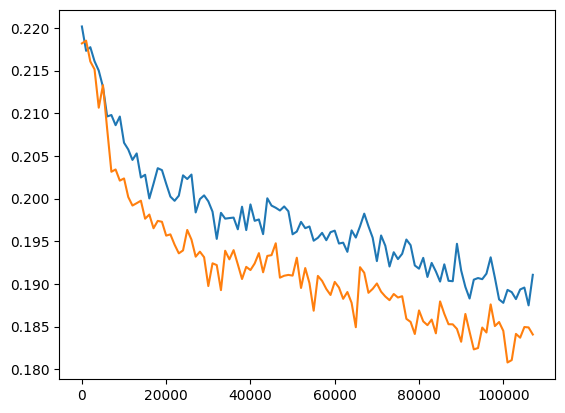

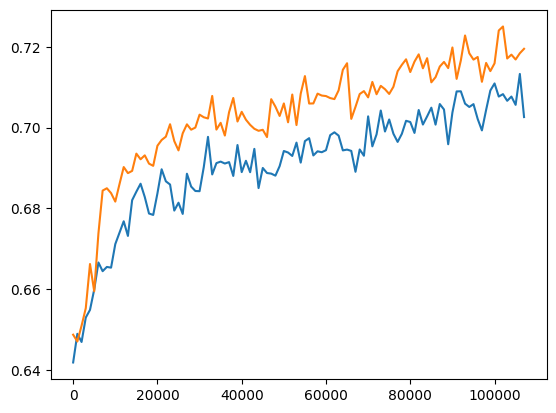

In [39]:
losses = [e["loss"] for e in log]
valid_losses = [e["valid_loss"] for e in log]

accs = [e["acc"] for e in log]
valid_accs = [e["valid_acc"] for e in log]

window = 1000

plt.plot(range(0, len(losses)-window, window), [np.mean(losses[i:i+window]) for i in range(0, len(losses)-window, window)])
plt.plot(range(0, len(losses)-window, window), [np.mean(valid_losses[i:i+window]) for i in range(0, len(valid_losses)-window, window)])
plt.show()

plt.plot(range(0, len(losses)-window, window), [np.mean(accs[i:i+window]) for i in range(0, len(accs)-window, window)])
plt.plot(range(0, len(losses)-window, window), [np.mean(valid_accs[i:i+window]) for i in range(0, len(valid_accs)-window, window)])
plt.show()

In [13]:
graph.load("models/generalize_82000.pt")

### Evaluate on Train digits, Test digits, Fashion test

In [14]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.main = nn.Sequential(
#             nn.Linear(SIZE**2, 8),
#             nn.ReLU(),
#             nn.Linear(8, n_classes),
#             nn.Softmax(1),
#         )
    
#     def forward(self, x):
#         # print(x.shape)
#         # x = x.reshape(*x.shape[:-2], -1)
#         # print(x.shape)
#         return self.main(x)

# def fit(model, x_train, y_train, steps=3):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
#     for _ in range(steps):
#         optimizer.zero_grad()
#         y_hat = model(x_train)
#         loss = criterion(y_hat, y_train)

#         loss.backward()
#         optimizer.step()

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1, 4, 4, 2),# SIZE**2, 8),
            nn.ReLU(),
            nn.Conv2d(4, 4, 4, 2),
            nn.ReLU(),
            nn.Flatten(),
            # nn.Linear(8, n)
            nn.Linear(144, n_classes),
            nn.Softmax(1),
        )
    
    def forward(self, x):
        # print(x.shape)
        # x = x.reshape(*x.shape[:-2], -1)
        # print(x.shape)
        return self.main(x.reshape(-1, 1, SIZE, SIZE))

def fit(model, x_train, y_train, steps=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    for _ in range(steps):
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)

        loss.backward()
        optimizer.step()

In [15]:
overall_accs = {}
overall_losses = {}

N = 2048

for data_name, dataset in {"cifar_test":cifar_test}.items():# , "mnist_test":mnist_test}.items():# ["valid"]:
    print(f"Data: {data_name}")

    accs = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}
    losses = {"graph":[], "linreg":[], "ANN_50_steps":[], "ANN_10_steps":[], "ANN_1_steps":[]}

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    bs = 64
    for b in tqdm(range(0, N, bs)):
        # Try graph
        with torch.no_grad():
            graph.init_vals(nodes=True, edges=True, batch_size=bs)

            graph.learn(x_train[b:b+bs], y_input[b:b+bs], time=TIME, dt=DT, apply_once=True, reset_nodes=True)
            pred = graph.predict(x_test[b:b+bs], time=TIME, dt=DT, apply_once=True, reset_nodes=True)

            graph_acc = (pred.argmax(-1) == y_test[b:b+bs]).float().mean()
            graph_loss = criterion(pred, y_label[b:b+bs])

            accs["graph"].append(graph_acc.item())
            losses["graph"].append(graph_loss.item())

    # Try linear regression and an ANN on each batch
    for x_train_b, y_train_b, x_test_b, y_test_b, y_input_b, y_label_b in tqdm(zip(x_train, y_train, x_test, y_test, y_input, y_label), total=N):
        model = LinearRegression()

        model.fit(x_train_b.cpu(), y_input_b.cpu())
        pred = torch.Tensor(model.predict(x_test_b.cpu())).to(device)

        linreg_acc = (pred.argmax(1) == y_test_b).float().mean()
        linreg_loss = criterion(pred, y_label_b)

        accs["linreg"].append(linreg_acc.item())
        losses["linreg"].append(linreg_loss.item())


        # Train model for 1, 10, 50 epochs and record acc / loss
        for steps in [1, 10, 50]:
            model = Model().to(device)

            fit(model, x_train_b, y_input_b, steps=steps)
            pred = model(x_test_b)

            model_acc = (pred.argmax(1) == y_test_b).float().mean()
            model_loss = criterion(pred, y_label_b)

            accs[f"ANN_{steps}_steps"].append(model_acc.item())
            losses[f"ANN_{steps}_steps"].append(model_loss.item())

    overall_accs[data_name] = {k:np.mean(v) for k, v in accs.items()}
    overall_losses[data_name] = {k:np.mean(v) for k, v in losses.items()}

Data: cifar_test


100%|██████████| 2048/2048 [03:16<00:00, 10.42it/s]


### After significantly more training valid didn't increase but specifically MNIST_test increased a lot

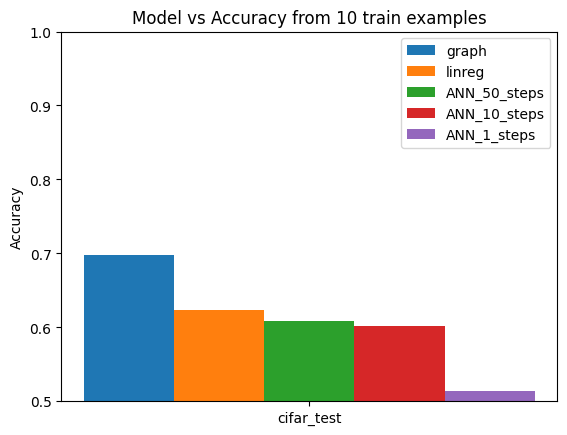

In [17]:
width=.05

plt.title("Model vs Accuracy from 10 train examples")

# plt.xticks(rotation='vertical')
plt.ylim(.5, 1)
plt.ylabel("Accuracy")

X = overall_accs.keys()
X_axis = np.arange(len(X))

plt.xticks(X_axis, X)

model_names = overall_accs[list(overall_accs.keys())[0]].keys()

for i, model_name in enumerate(model_names):
    accs = []
    for data_set in X:
        accs.append(overall_accs[data_set][model_name])
    plt.bar(X_axis + i*(width) - (len(model_names)-1)*(width/2), accs, width, label=model_name)
    

plt.legend(loc="upper right")
plt.savefig("cifar_results.png")
plt.show()

In [54]:
SIZE = 7

emnist = pd.read_csv("emnist-letters-train.csv").values

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist49 = split_dataset(x, y)

SIZE = 28

x, y = emnist[:, 1:], emnist[:, 0]
x = np.stack([cv2.resize(cv2.flip(cv2.rotate(img.reshape(28, 28)/255.0, cv2.ROTATE_90_CLOCKWISE), 1), dsize=[SIZE, SIZE]) for img in x]).reshape(-1, SIZE**2)

_, _, emnist784 = split_dataset(x, y)

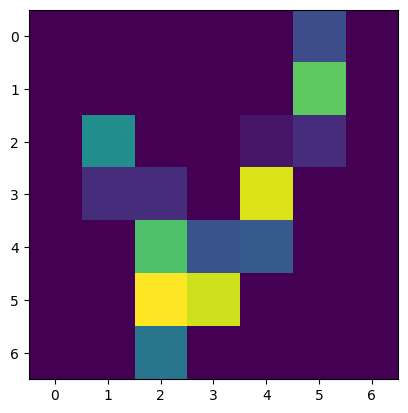

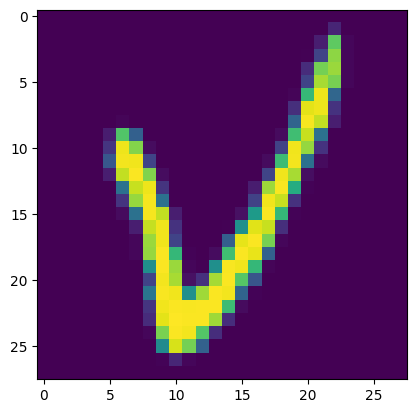

In [55]:
plt.imshow(emnist49[22][0].reshape(7, 7))
plt.show()
plt.imshow(emnist784[22][0].reshape(28, 28))
plt.show()

In [56]:
shape = [49, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph49 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph49.load("models/generalize_10000.pt")

shape = [784, 8, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph784 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph784.load("models/generalize_10000.pt")

408
6288


In [57]:
N = 2048

accs = {}
losses = {}

for data_name, dataset, g in zip(["emnist 7x7", "emnist 14x14", "emnist 28x28"], [emnist49, emnist_test, emnist784], [graph49, graph, graph784]):
    print(f"Data: {data_name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=dataset, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[data_name] = acc.item()
        losses[data_name] = loss.item()

Data: emnist 7x7
Data: emnist 14x14
Data: emnist 28x28


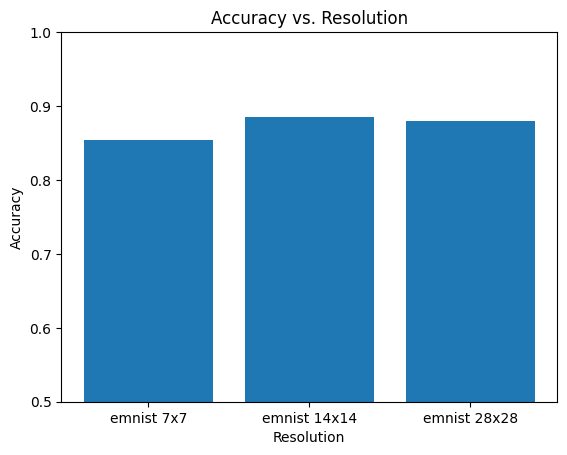

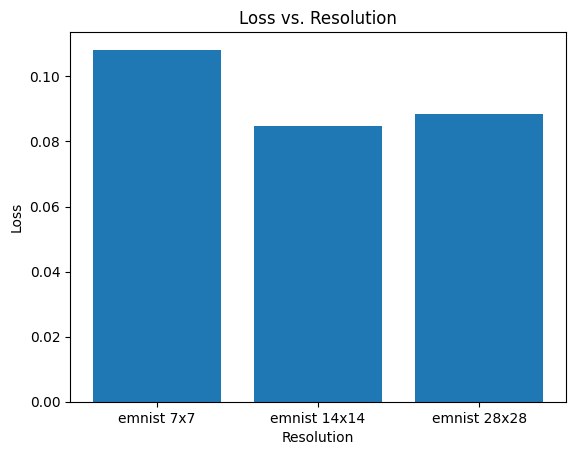

In [60]:
plt.title("Accuracy vs. Resolution")
plt.xlabel("Resolution")
plt.ylabel("Accuracy")
plt.bar(accs.keys(), accs.values())
plt.ylim(.5, 1)
plt.savefig("resolutions.png")
plt.show()


plt.title("Loss vs. Resolution")
plt.xlabel("Resolution")
plt.ylabel("Loss")
plt.bar(losses.keys(), losses.values())
plt.show()

In [61]:
shape = [14**2, 4, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h4 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h4.load("models/generalize_10000.pt")

shape = [14**2, 16, n_classes]
n_nodes = sum(shape)
connections = [(sum(shape[:i])+x, sum(shape[:i+1])+y) for i in range(len(shape)-1) for x in range(shape[i]) for y in range(shape[i+1])]

print(len(connections))

graph_h16 = NeuralGraph(n_nodes, shape[0], shape[-1], connections,
    ch_n=8, ch_e=8, value_init="random", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, 
    device=device)

graph_h16.load("models/generalize_10000.pt")

792
3168


In [63]:
accs = {}
losses = {}

for name, g in zip(["4 hidden", "8 hidden", "16 hidden"], [graph_h4, graph, graph_h16]):
    print(f"Data: {name}")

    x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=emnist_test, batch_size=N)
    y_input = nn.functional.one_hot(y_train, n_classes).float()
    y_label = nn.functional.one_hot(y_test, n_classes).float()
    
    # Try graph
    with torch.no_grad():
        g.init_vals(nodes=True, edges=True, batch_size=N)

        g.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
        pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

        acc = (pred.argmax(2) == y_test).float().mean()
        loss = criterion(pred, y_label)
        
        accs[name] = acc.item()
        losses[name] = loss.item()

Data: 4 hidden
Data: 8 hidden
Data: 16 hidden


In [64]:
print(accs)

{'4 hidden': 0.884960949420929, '8 hidden': 0.887011706829071, '16 hidden': 0.8814453482627869}


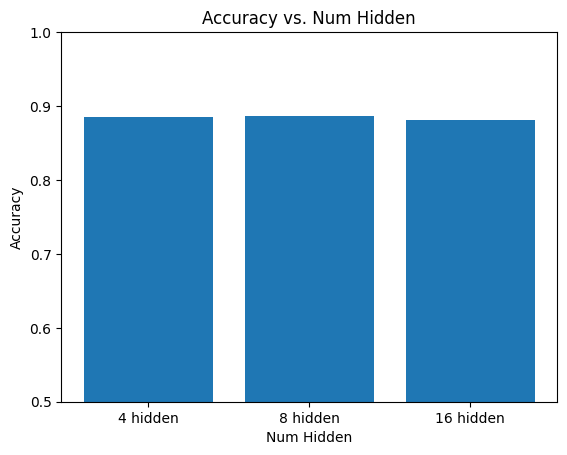

In [66]:
plt.title("Accuracy vs. Num Hidden")
plt.xlabel("Num Hidden")
plt.ylabel("Accuracy")
plt.bar(accs.keys(), accs.values())
plt.ylim(.5, 1)
plt.savefig("hidden.png")
plt.show()

In [15]:
print(connections[:1024*8:8])

1024


In [19]:
x_train, y_train, x_test, y_test, classes = get_batch_data(dataset=cifar_train, batch_size=1)

y_input = nn.functional.one_hot(y_train, n_classes).float()
y_label = nn.functional.one_hot(y_test, n_classes).float()

# graph.init_vals(batch_size=1)

graph.init_vals(nodes=True, edges=True, batch_size=1)

graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
# pred = g.predict(x_test, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

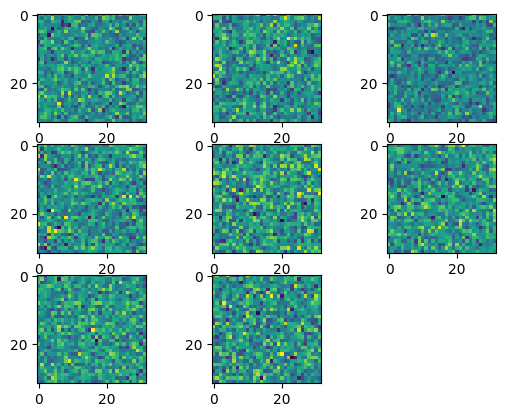

In [31]:
for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(nn.functional.sigmoid(graph.init_edges[0:1024*8:8, i].reshape(32, 32).cpu().detach()))
plt.show()

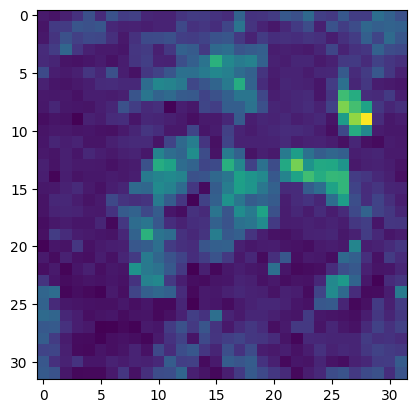

In [35]:
plt.imshow(graph.edges[0, 1:1024*8:8].reshape(32, 32, 8).abs().mean(-1).cpu().detach())
plt.show()

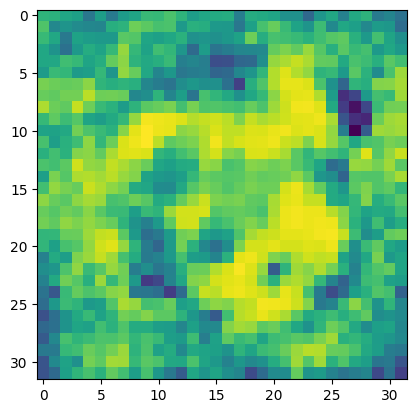

In [22]:
plt.imshow(graph.edges[0, :1024*8:8].reshape(32, 32, 8).mean(-1).cpu().detach())
plt.show()

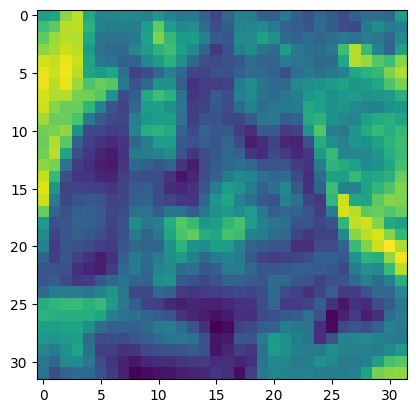

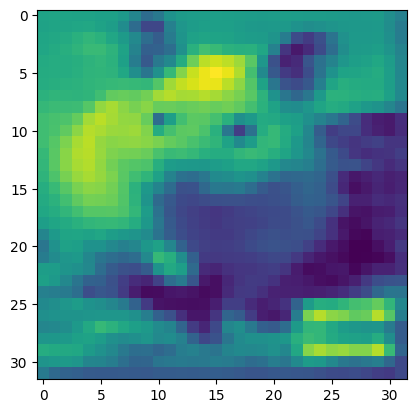

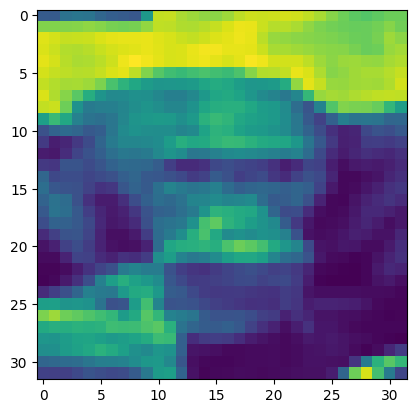

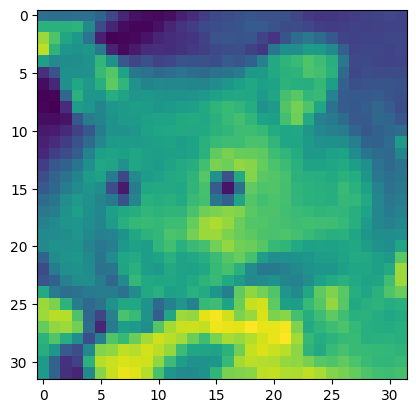

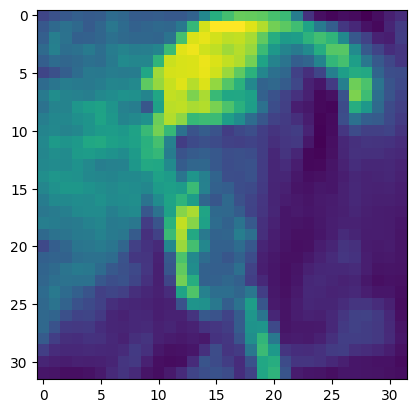

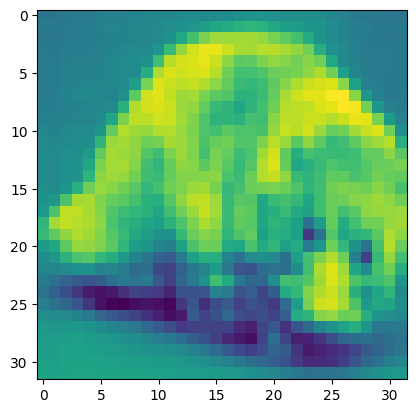

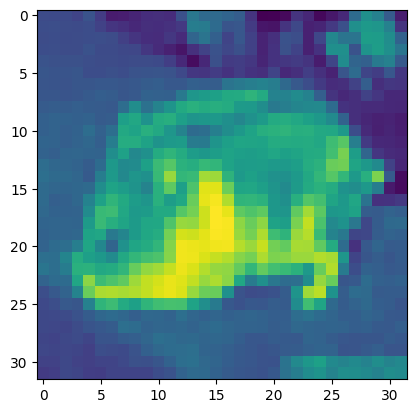

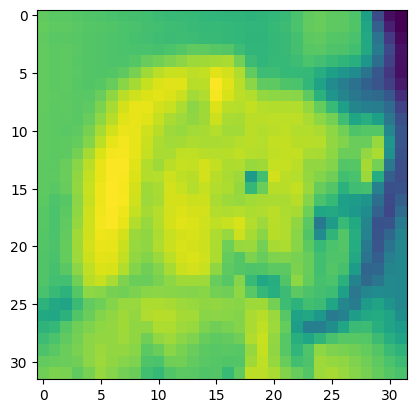

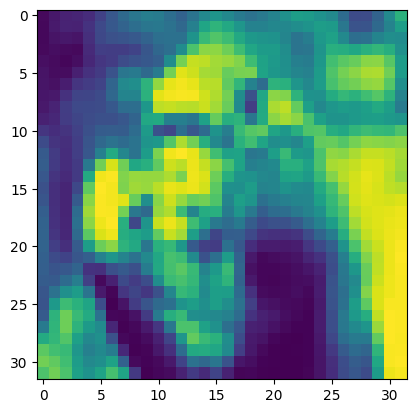

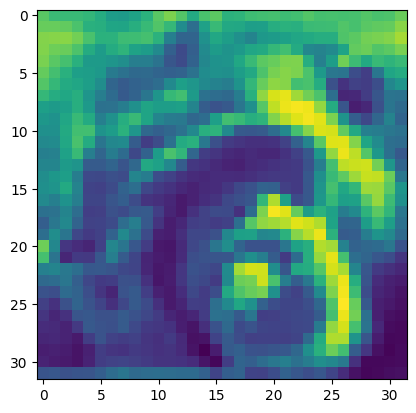

In [18]:
for img in x_train[0]:
    plt.imshow(img.reshape(32, 32).cpu().detach().numpy())
    plt.show()

In [30]:
print(x_train.shape)

torch.Size([1, 10, 1024])
